In [3]:
import proplot as plot
import numpy as np
import yaml
import glob
import copy

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import logging
import sys

import pizza_cutter

logging.basicConfig(stream=sys.stdout)
for code in ["ngmix", "metadetect", "pizza_cutter", "pizza_cutter_sims"]:
    logging.getLogger(code).setLevel(
        getattr(logging, "DEBUG"))

In [5]:
import tempfile
from pizza_cutter_sims.pizza_cutter import run_des_pizza_cutter_coadding_on_sim
from pizza_cutter_sims.sim import generate_sim
from pizza_cutter_sims.constants import PIXEL_SCALE
from pizza_cutter_sims.mdet import run_metadetect
from pizza_cutter_sims.stars import mask_and_interp_stars

with open(glob.glob("../runs/run0032_wcs-None_gals-Bh_msk-e16_coadd-None_stars-fg1/config.yaml")[0]) as fp:
    base_cfg = yaml.safe_load(fp.read())


# with open(glob.glob("ref_config.yaml")[0]) as fp:
#     base_cfg = yaml.safe_load(fp.read())
    
# base_cfg["se"]["n_images"] = 2
# base_cfg["pizza_cutter"]["single_epoch_config"]["spline_interp_flags"] = [7]

In [22]:
import tqdm

rng = np.random.RandomState()
seeds = rng.randint(low=1, high=2**29, size=5)

all_msk_keys = ["bad_columns", "cosmic_rays", "streaks", "star"]
all_msk_keys = ["star"]
results = {}
for msk_key in tqdm.tqdm(["star"]):
    rng = np.random.RandomState(seed=seeds[0])
    gal_rng = np.random.RandomState(seed=seeds[1])
    star_rng = np.random.RandomState(seed=seeds[1])
    coadd_rng = np.random.RandomState(seed=seeds[2])
    mdet_rng = np.random.RandomState(seed=seeds[3])

    cfg = copy.deepcopy(base_cfg)
    for key in all_msk_keys:
        if key != "star":
            cfg["msk"][key] = False
    for key in all_msk_keys:
        if key == "star":
            continue
        cfg["msk"][key] = True
        if key == msk_key:
            break
    
    if msk_key == "star":
        cfg["star"]["dens_factor"] = 1
    else:
        cfg["star"]["dens_factor"] = 0

    data = generate_sim(
        rng=rng,
        gal_rng=gal_rng,
        star_rng=star_rng,
        coadd_config=cfg["coadd"],
        se_config=cfg["se"],
        psf_config=cfg["psf"],
        gal_config=cfg["gal"],
        star_config=cfg["star"],
        layout_config=cfg["layout"],
        msk_config=cfg["msk"],
        shear_config=cfg["shear"],
        skip_coadding=False,
    )

    with tempfile.TemporaryDirectory() as tmpdir:
        cdata = run_des_pizza_cutter_coadding_on_sim(
            rng=coadd_rng,
            tmpdir=tmpdir,
            single_epoch_config=cfg["pizza_cutter"]["single_epoch_config"],
            img=data["img"],
            wgt=data["wgt"],
            msk=data["msk"],
            bkg=data["bkg"],
            info=data["info"],
            n_extra_noise_images=0,
        )
        
    mask_and_interp_stars(
        cdata=cdata, 
        stars=data["stars"], 
        rng=star_rng,
        interp_cfg=cfg["star"]["interp"],
    )
    
    results[msk_key] = cdata

  0%|                                                                                                                                                           | 0/1 [00:00<?, ?it/s]

DEBUG:pizza_cutter_sims.wcs:generated wcs: galsim.AffineTransform(0.263, 0.0, 0.0, 0.263, origin=galsim.PositionD(x=233.0, y=233.0), world_origin=galsim.PositionD(x=0.0, y=0.0))
DEBUG:pizza_cutter_sims.psf:psf config: {'type': 'Gaussian', 'fwhm': 0.9, 'shear': {'type': 'G1G2', 'g1': 0.0, 'g2': 0.0}}
DEBUG:pizza_cutter_sims.psf:galsim psf: galsim.Gaussian(sigma=0.3821948101296086).transform(1.0,0.0,0.0,1.0)
DEBUG:pizza_cutter_sims.gals:using 'exp-super-bright' gal type w/ mag 14.0
INFO:pizza_cutter.des_pizza_cutter._load_info:loading image data products for coadd/coadd
INFO:pizza_cutter.des_pizza_cutter._load_info:loading image data products for epoch0/epoch0
INFO:pizza_cutter.des_pizza_cutter._coadd_slices:generating slice objects for ra,dec = 0.0|0.0
DEBUG:pizza_cutter.des_pizza_cutter._coadd_slices:found possible image epoch0/epoch0
INFO:pizza_cutter.des_pizza_cutter._coadd_slices:images found in rough cut: 1
INFO:pizza_cutter.des_pizza_cutter._coadd_slices:pre-processing image epoch

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.79s/it]


In [23]:
mdet_res = run_metadetect(
    rng=mdet_rng,
    config=cfg["metadetect"],
    wcs=data["info"]["affine_wcs"],
    image=cdata["image"],
    bmask=cdata["bmask"],
    ormask=cdata["ormask"],
    noise=cdata["noise"],
    psf=cdata["psf"],
    weight=cdata["weight"],
    mfrac=cdata["mfrac"],
    mask_catalog=data["stars"],
    mask_expand_rad=cfg["star"]["mask_expand_rad"]
)

DEBUG:ngmix.metacal.convenience:    Doing fixnoise with input noise image
DEBUG:metadetect.detect:box sizes: [64 64 64 64 48 64 64 48 64 48 64 64 64 64 64 64 64 64 64 48 64 64 64 64
 64 64 64 48 64 64 64 64 64 64 48 64 48 48 64 64 64 64 48 64 64 64 48 64
 48 64 48 64 48 64 64 48 48 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64
 64 64 64 64 48 32 64 32 64 64 64 64 48 64 64 32 64 64 64 64 64 64 64 64
 64 64 64]
DEBUG:metadetect.detect:minmax: 32 64
DEBUG:metadetect.fitting:        wmom s2n: 21243.4 Trat: 1.48445
DEBUG:metadetect.fitting:        wmom s2n: 21243 Trat: 1.48458
DEBUG:metadetect.fitting:        wmom s2n: 21243.1 Trat: 1.48467
DEBUG:metadetect.fitting:        wmom s2n: 21242.2 Trat: 1.48455
DEBUG:metadetect.fitting:        wmom s2n: 21139.2 Trat: 1.47542
DEBUG:metadetect.fitting:        wmom s2n: 21244.3 Trat: 1.48451
DEBUG:metadetect.fitting:        wmom s2n: 21243.6 Trat: 1.48451
DEBUG:metadetect.fitting:        wmom s2n: 11509.1 Trat: 1.15602
DEBUG:metadetect.fitting:       

DEBUG:metadetect.fitting:        wmom s2n: 21238 Trat: 1.48467
DEBUG:metadetect.fitting:        wmom s2n: 21238.7 Trat: 1.48459
DEBUG:metadetect.fitting:        wmom s2n: 21237.7 Trat: 1.48466
DEBUG:metadetect.fitting:        wmom s2n: 21239.9 Trat: 1.48459
DEBUG:metadetect.fitting:        wmom s2n: 21239.4 Trat: 1.4846
DEBUG:metadetect.fitting:        wmom s2n: 21238.8 Trat: 1.48457
DEBUG:metadetect.fitting:        wmom s2n: 21239.6 Trat: 1.48465
DEBUG:metadetect.fitting:        wmom s2n: 21240.5 Trat: 1.48464
DEBUG:metadetect.fitting:        wmom s2n: 21240.7 Trat: 1.48464
DEBUG:metadetect.fitting:        wmom s2n: 21239.1 Trat: 1.48453
DEBUG:metadetect.fitting:        wmom s2n: 21177.4 Trat: 1.47947
DEBUG:metadetect.fitting:        wmom s2n: 21240.4 Trat: 1.48457
DEBUG:metadetect.fitting:        wmom s2n: 21233.1 Trat: 1.48417
DEBUG:metadetect.fitting:        wmom s2n: 21240.5 Trat: 1.48457
DEBUG:metadetect.fitting:        wmom s2n: 21241 Trat: 1.48466
DEBUG:metadetect.fitting:     

DEBUG:metadetect.fitting:        wmom s2n: 21247.6 Trat: 1.48449
DEBUG:metadetect.fitting:        wmom s2n: 11006.1 Trat: 1.1483
DEBUG:metadetect.fitting:        wmom s2n: 1747.85 Trat: 0.75477
DEBUG:metadetect.fitting:        wmom s2n: 21246.7 Trat: 1.48452
DEBUG:metadetect.fitting:        wmom s2n: 21247.3 Trat: 1.48455
DEBUG:metadetect.fitting:        wmom s2n: 21246.1 Trat: 1.48446
DEBUG:metadetect.fitting:        wmom s2n: 21247 Trat: 1.48455
DEBUG:metadetect.fitting:        wmom s2n: 21247 Trat: 1.48445
DEBUG:metadetect.fitting:        wmom s2n: 21244.7 Trat: 1.48448
DEBUG:metadetect.fitting:        wmom s2n: 21247.1 Trat: 1.48453
DEBUG:metadetect.fitting:        wmom s2n: 21246.4 Trat: 1.4846
DEBUG:metadetect.fitting:        wmom s2n: 21245.7 Trat: 1.48454
DEBUG:metadetect.fitting:        wmom s2n: 21247.8 Trat: 1.4846
DEBUG:metadetect.fitting:        wmom s2n: 21248.2 Trat: 1.48442
DEBUG:metadetect.fitting:        wmom s2n: 21244.4 Trat: 1.48453
DEBUG:metadetect.fitting:       

DEBUG:metadetect.fitting:        wmom s2n: 21242.3 Trat: 1.48462
DEBUG:metadetect.fitting:        wmom s2n: 21243.7 Trat: 1.48463
DEBUG:metadetect.fitting:        wmom s2n: 21243.3 Trat: 1.48455
DEBUG:metadetect.fitting:        wmom s2n: 21240.6 Trat: 1.4846
DEBUG:metadetect.fitting:        wmom s2n: 20538.4 Trat: 1.42311
DEBUG:metadetect.fitting:        wmom s2n: 21244.6 Trat: 1.4847
DEBUG:metadetect.fitting:        wmom s2n: 21244.1 Trat: 1.48469
DEBUG:metadetect.fitting:        wmom s2n: 21242.1 Trat: 1.48452
DEBUG:metadetect.fitting:        wmom s2n: 21242 Trat: 1.48455
DEBUG:metadetect.fitting:        wmom s2n: 2497.47 Trat: 1.12918
DEBUG:metadetect.fitting:        wmom s2n: 21244 Trat: 1.48453
DEBUG:metadetect.fitting:        wmom s2n: 21241 Trat: 1.48457
DEBUG:metadetect.fitting:        wmom s2n: 21242.8 Trat: 1.48453
DEBUG:metadetect.fitting:        wmom s2n: 21242.3 Trat: 1.48455
DEBUG:metadetect.fitting:        wmom s2n: 21242.2 Trat: 1.48457
DEBUG:metadetect.fitting:        

DEBUG:metadetect.fitting:        wmom s2n: 21241.9 Trat: 1.48453
DEBUG:metadetect.fitting:        wmom s2n: 21243.2 Trat: 1.48457
DEBUG:metadetect.fitting:        wmom s2n: 21243.6 Trat: 1.48458
DEBUG:metadetect.fitting:        wmom s2n: 21240.9 Trat: 1.48457
DEBUG:metadetect.fitting:        wmom s2n: 21244.3 Trat: 1.48455
DEBUG:metadetect.fitting:        wmom s2n: 21243.7 Trat: 1.4845
DEBUG:metadetect.fitting:        wmom s2n: 21242.9 Trat: 1.48443
DEBUG:metadetect.fitting:        wmom s2n: 21242.2 Trat: 1.48452
DEBUG:metadetect.fitting:        wmom s2n: 21240.6 Trat: 1.48454
DEBUG:metadetect.fitting:        wmom s2n: 21242.5 Trat: 1.48451
DEBUG:metadetect.fitting:        wmom s2n: 21241.8 Trat: 1.48458
DEBUG:metadetect.fitting:        wmom s2n: 21240.6 Trat: 1.48451
DEBUG:metadetect.fitting:        wmom s2n: 21244.5 Trat: 1.48453
DEBUG:metadetect.fitting:        wmom s2n: 21242.7 Trat: 1.48457
DEBUG:metadetect.fitting:        wmom s2n: 21242.1 Trat: 1.48458
DEBUG:metadetect.fitting: 

In [ ]:
fig, axs = plot.subplots(figsize=(12, 12))
cdata = results["star"]

img = cdata["image"].copy()
msk = cdata['mfrac'] == 1
# img[msk] = np.nan

key = "image"
axs.pcolormesh(img, cmap="rocket")
axs.plot(mdet_res['noshear']['sx_col_noshear'], mdet_res['noshear']['sx_row_noshear'], 'b.')

axs.plot(mdet_res['1p']['sx_col'], mdet_res['1p']['sx_row'], '+', color='cyan')
axs.plot(mdet_res['1m']['sx_col'], mdet_res['1m']['sx_row'], '+', color='green')

axs.plot(mdet_res['2p']['sx_col'], mdet_res['2p']['sx_row'], 'x', color='cyan')
axs.plot(mdet_res['2m']['sx_col'], mdet_res['2m']['sx_row'], 'x', color='green')


axs.set_aspect(1)
axs.set_title(key)
axs.set_xlim(0, img.shape[1])

fig.savefig('star_sel.pdf')


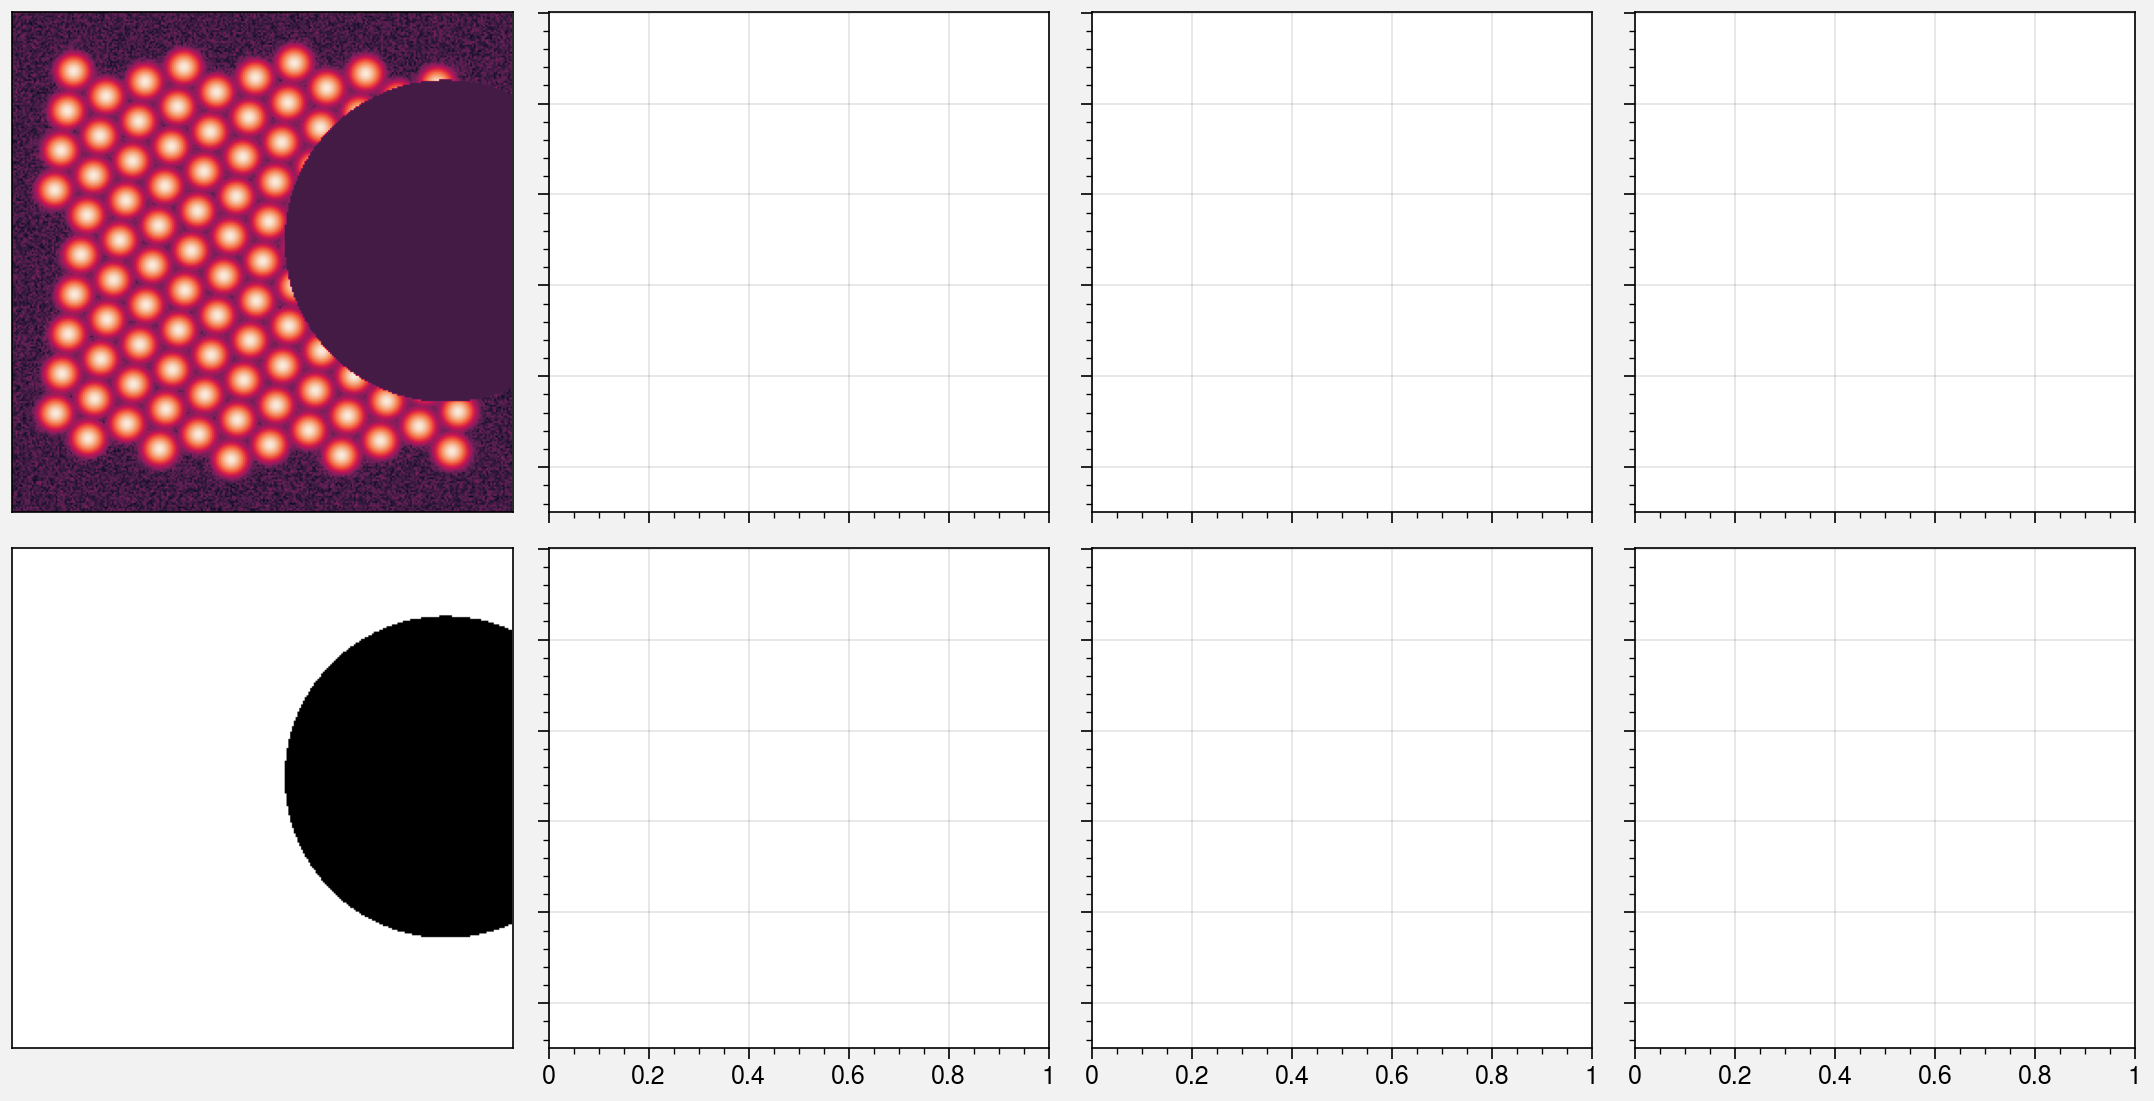

In [7]:
vmin = np.inf
vmax = -np.inf

for i, key in enumerate(all_msk_keys):
    img = results[key]["image"]
    wgt = results[key]["weight"]
    ormask = results[key]["ormask"]
    vv = np.arcsinh(img*np.sqrt(wgt))
    vmin = min(np.min(vv), vmin)
    vmax = max(np.max(vv), vmax)

fig, axs = plot.subplots(nrows=2, ncols=4, share=3)
for i, key in enumerate(all_msk_keys):
    img = results[key]["image"]
    wgt = results[key]["weight"]
    ormask = results[key]["ormask"]
    ax = axs[0, i]
    ax.imshow(np.arcsinh(img*np.sqrt(wgt)), cmap="rocket", vmin=vmin, vmax=vmax)
    ax.grid(False)
    ax.format(xtickloc='neither', ytickloc='neither')
    
    ax = axs[1, i]
    ax.imshow(ormask.astype(bool), cmap="gray_r", vmin=0, vmax=1)    
    ax.grid(False)
    ax.format(xtickloc='neither', ytickloc='neither')
    
fig.savefig("msk.png")

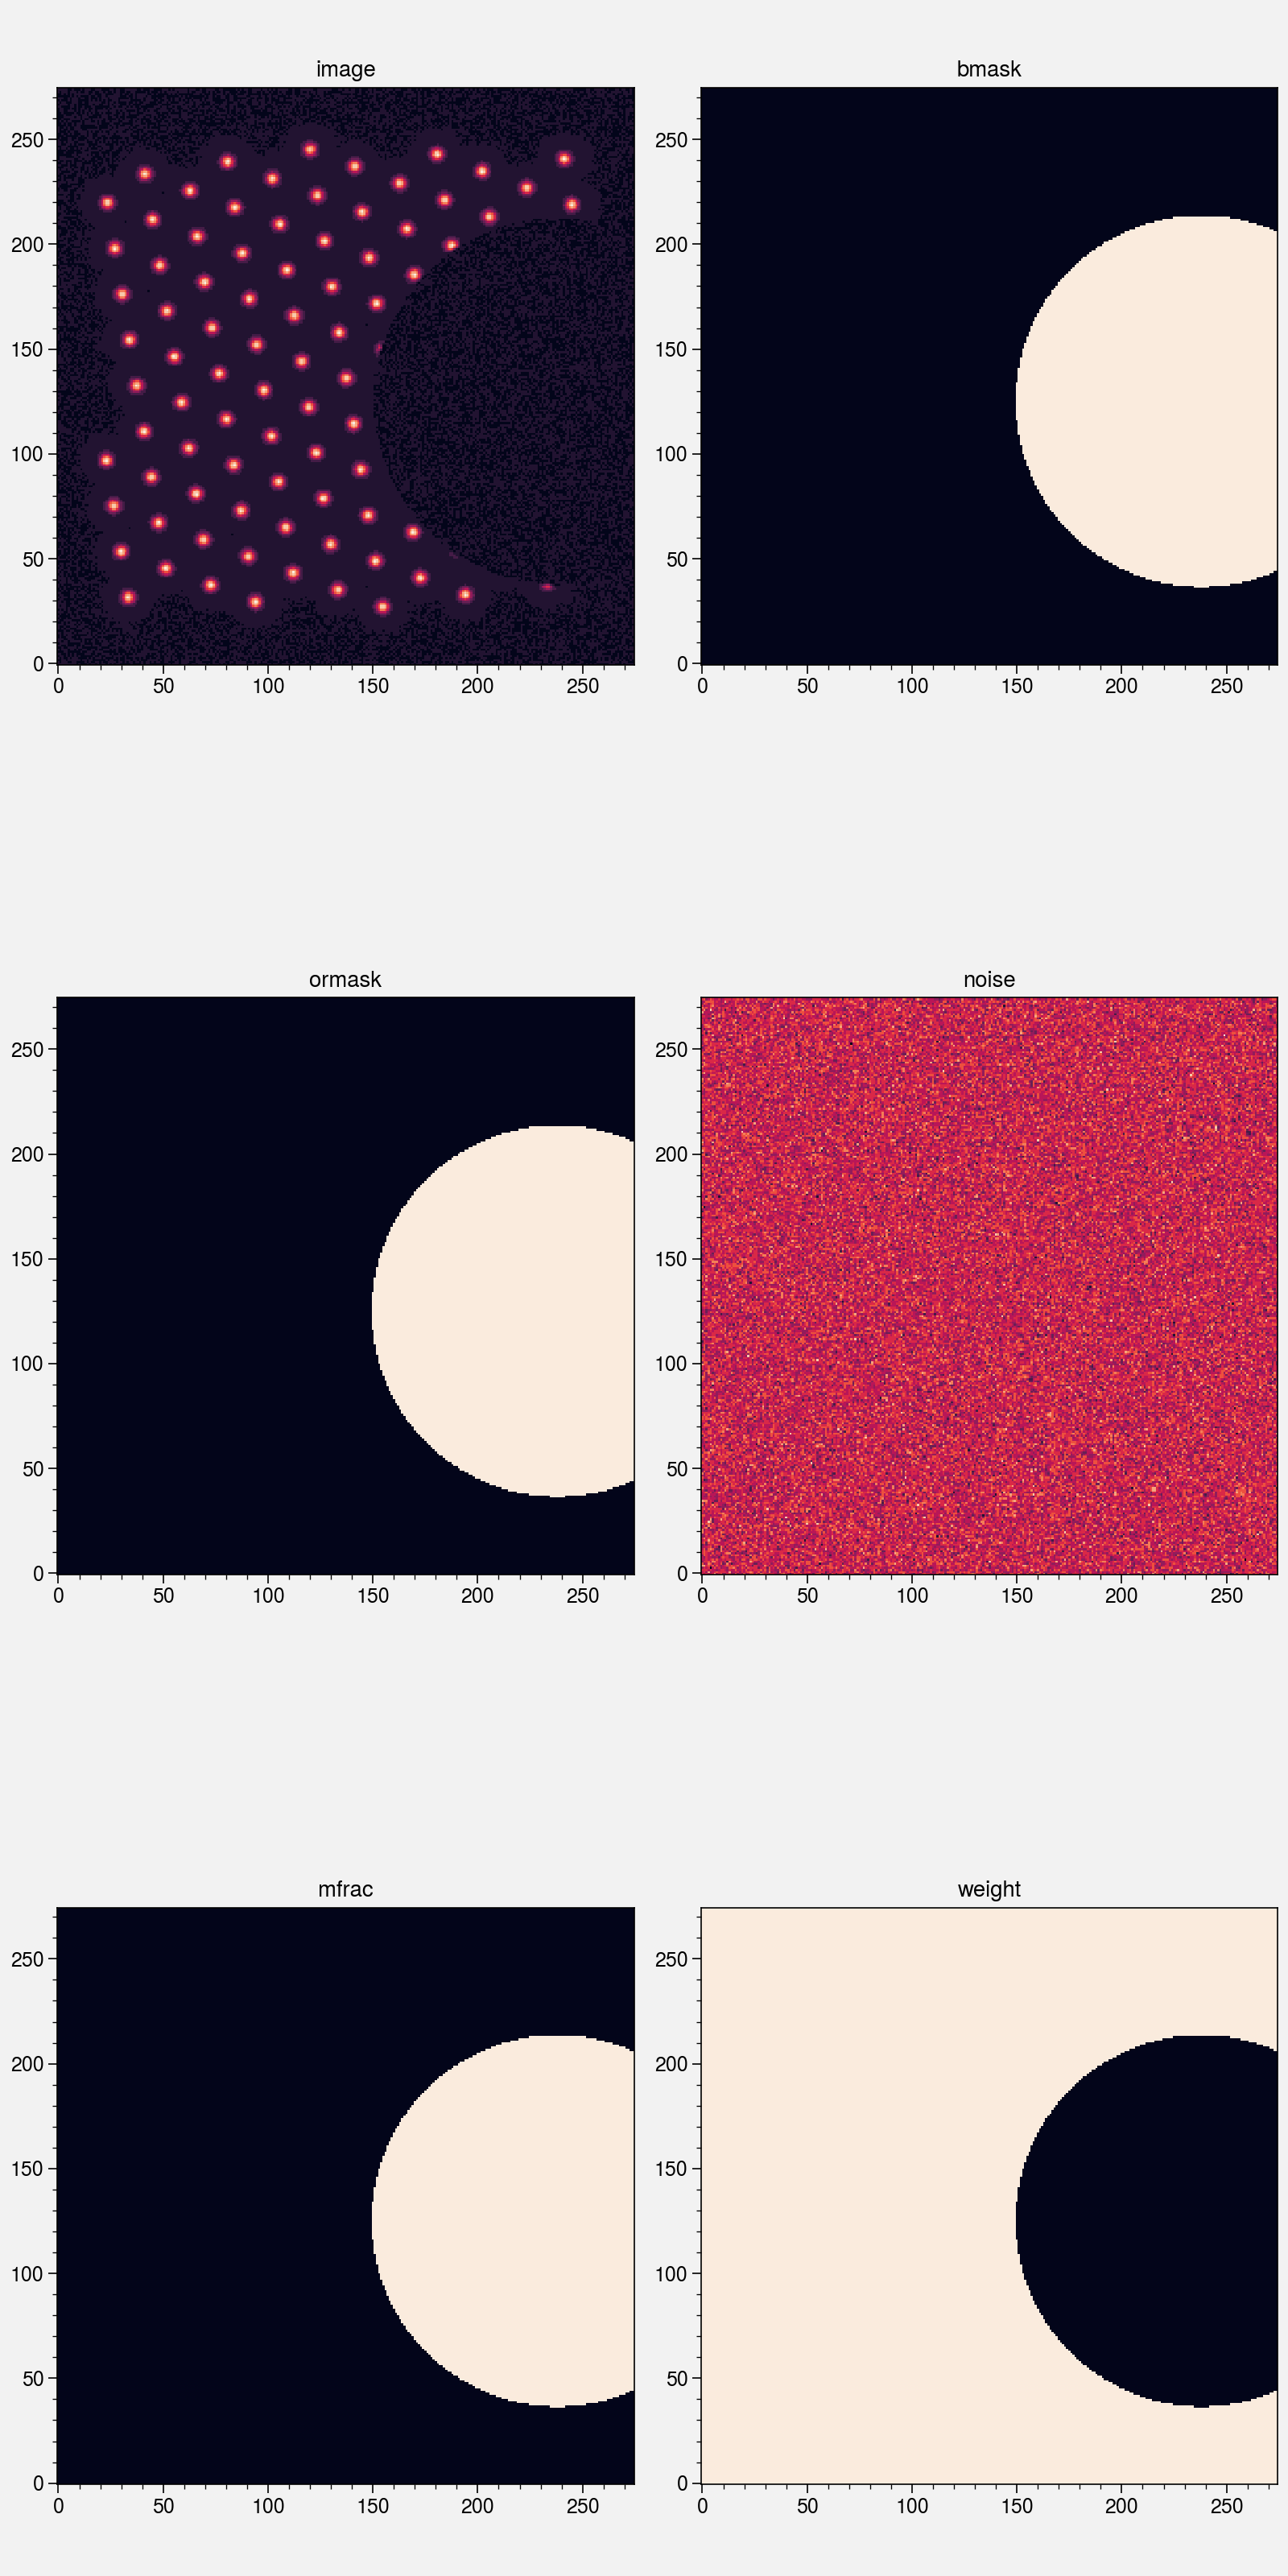

In [8]:
fig, axs = plot.subplots(nrows=3, ncols=2, figsize=(8, 16), share=0)
cdata = results["star"]

for i, key in enumerate(["image", "bmask", "ormask", "noise", "mfrac", "weight"]):
    axs[i].pcolormesh(cdata[key], cmap="rocket")
    axs[i].set_aspect(1)
    axs[i].set_title(key)

Text(0.5, 1.0, 'image')

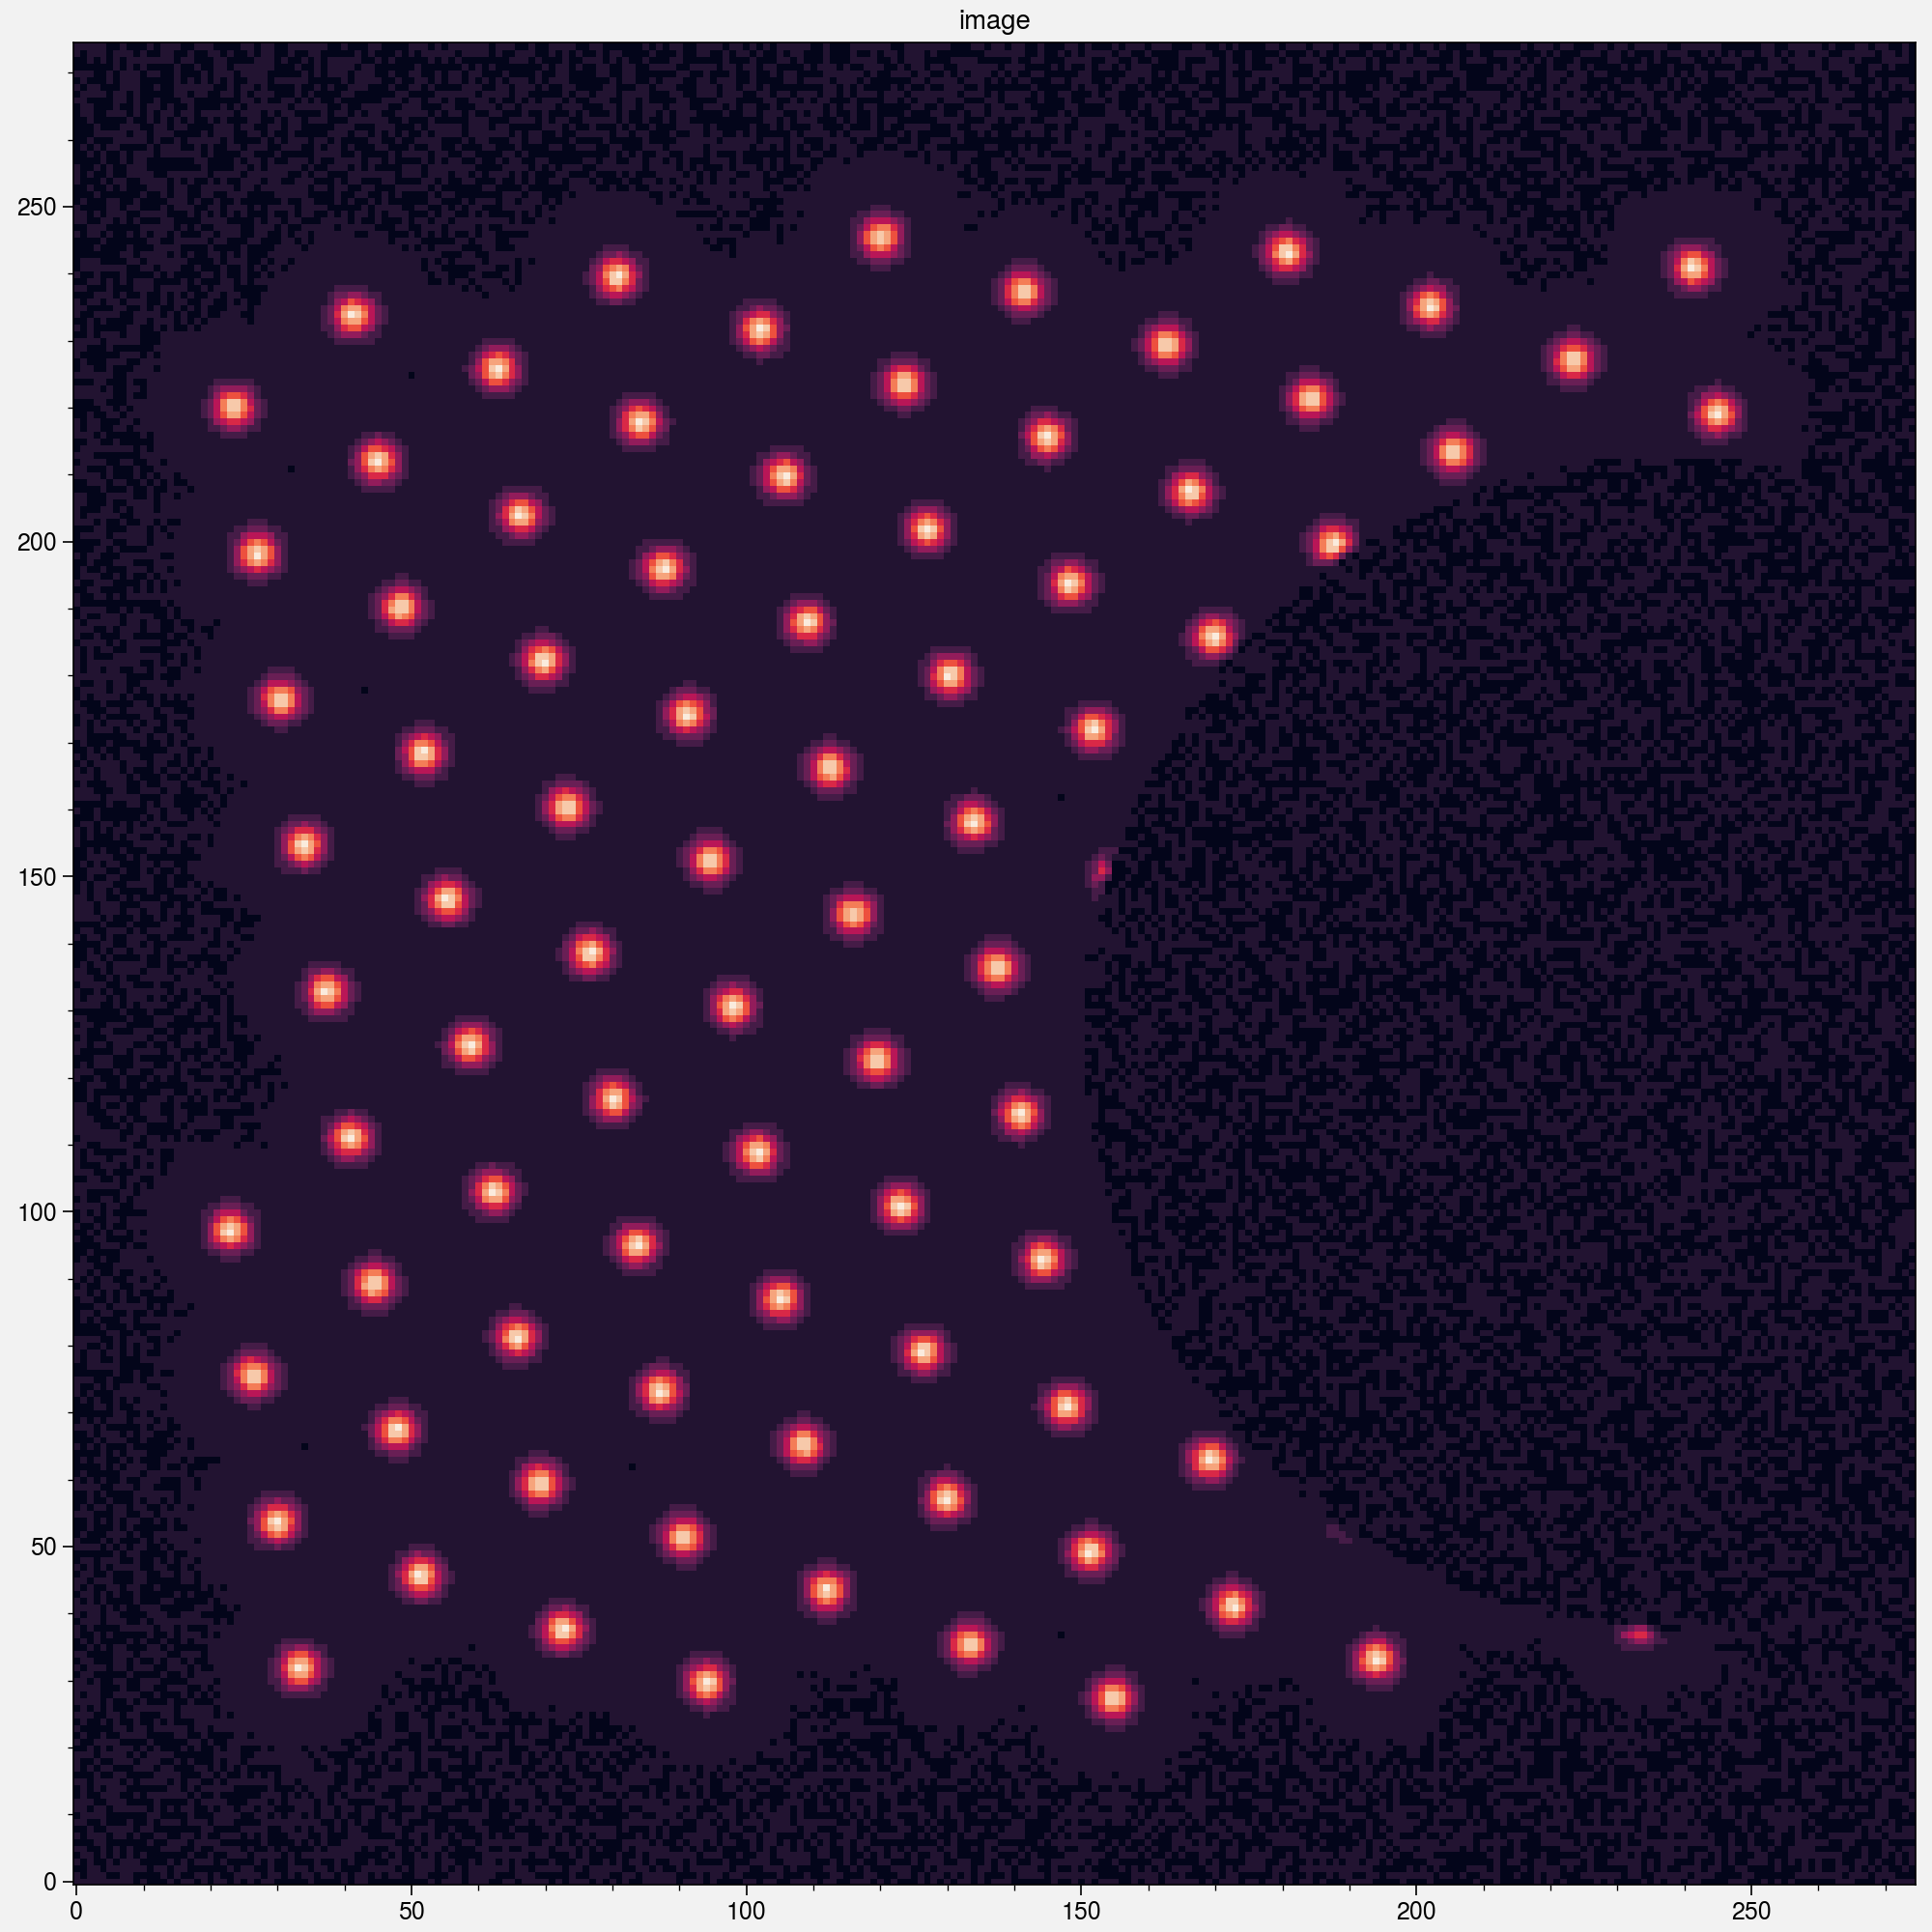

In [9]:
fig, axs = plot.subplots(figsize=(10, 10))
cdata = results["star"]

key = "image"
axs.pcolormesh(cdata[key], cmap="rocket")
axs.set_aspect(1)
axs.set_title(key)